# Data: Lake Michigan Waves

https://data.cityofchicago.org/Parks-Recreation/Beach-Water-Quality-Automated-Sensors/qmqz-2xku

Can we predict wave height based on wave period (time between waves)?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [2]:
df = pd.read_csv("waves.csv")
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Ohio Street Beach,06/02/2019 05:00:00 PM,17.1,0.78,NaN,0.232,4.0,10.9,06/02/2019 5:00 PM,OhioStreetBeach201906021700
1,63rd Street Beach,09/18/2013 10:00:00 AM,18.9,7.56,1.517,0.140,4.0,11.0,09/18/2013 10:00 AM,63rdStreetBeach201309181000
2,63rd Street Beach,06/12/2014 12:00:00 PM,25.4,3.45,-0.072,0.031,9.0,12.2,06/12/2014 12:00 PM,63rdStreetBeach201406121200
3,63rd Street Beach,06/12/2014 01:00:00 PM,18.1,3.31,1.818,0.339,10.0,12.2,06/12/2014 1:00 PM,63rdStreetBeach201406121300
4,63rd Street Beach,06/12/2014 02:00:00 PM,17.5,2.93,1.545,0.136,4.0,12.2,06/12/2014 2:00 PM,63rdStreetBeach201406121400


<AxesSubplot:xlabel='Wave Period', ylabel='Wave Height'>

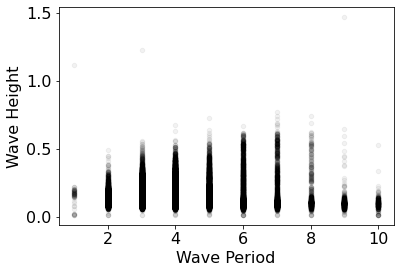

In [3]:
df = df[(df["Wave Period"] > 0) & (df["Wave Height"] > 0)]
df.plot.scatter(x="Wave Period", y="Wave Height", color="k", alpha=0.05)
# observation: non-linear relationship

In [4]:
beach_names = sorted(set(df["Beach Name"]))
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

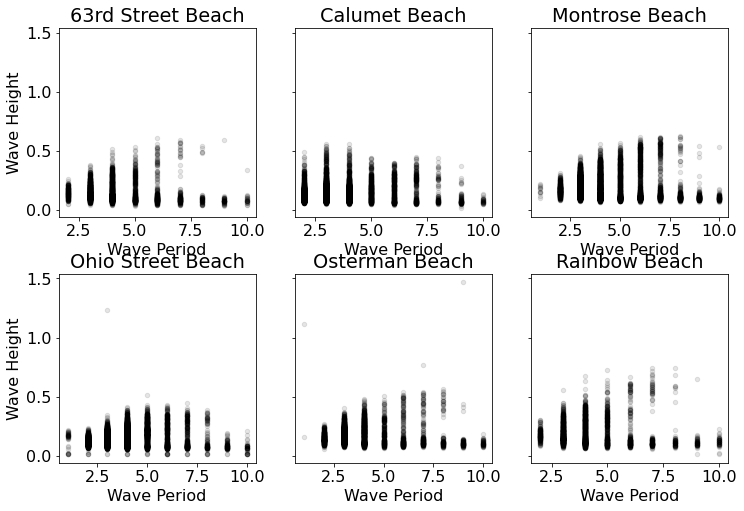

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.3)
axes = list(axes.reshape(-1))
for b in beach_names:
    ax = axes.pop(0)
    ax.set_title(b)
    beach_df = df[df["Beach Name"] == b]
    beach_df.plot.scatter(x="Wave Period", y="Wave Height", 
                          color="k", alpha=0.1, ax=ax)
# obversation: which beach (categorical feature) is important

# Four Models

1. wave period (linear)
2. wave period (polynomial)
3. beach
4. beach and wave period

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [18]:
train, test = train_test_split(df, random_state=320)
train.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
15640,Montrose Beach,09/06/2015 02:00:00 PM,14.8,0.04,NaN,0.181,3.0,11.0,09/06/2015 2:00 PM,MontroseBeach201509061400
1800,63rd Street Beach,06/23/2015 10:00:00 AM,17.1,1.11,NaN,0.250,3.0,9.9,06/23/2015 10:00 AM,63rdStreetBeach201506231000
36612,Ohio Street Beach,07/18/2018 10:00:00 PM,23.7,1.80,NaN,0.214,4.0,10.8,07/18/2018 10:00 PM,OhioStreetBeach201807182200
5398,Calumet Beach,08/21/2014 07:00:00 PM,23.1,0.40,1.355,0.125,2.0,10.3,08/21/2014 7:00 PM,CalumetBeach201408211900
12992,Montrose Beach,08/22/2014 03:00:00 PM,23.7,0.27,1.777,0.151,3.0,10.5,08/22/2014 3:00 PM,MontroseBeach201408221500


## Model 1: Wave Period (Linear)

In [21]:
m1 = LinearRegression()
cross_val_score(m1, train[["Wave Period"]], train["Wave Height"]).mean()

0.0016982079135994476

## Model 2: Wave Period (Polynomial)

In [25]:
example = df[["Wave Period"]].copy()
example["Wave Period^2"] = example["Wave Period"] ** 2
example["Wave Period^3"] = example["Wave Period"] ** 3
example["sqrt(Wave Period)"] = example["Wave Period"] ** 0.5
example

,Wave Period,Wave Period^2,Wave Period^3,sqrt(Wave Period)
0,4.0,16.0,64.0,2.000000
1,4.0,16.0,64.0,2.000000
2,9.0,81.0,729.0,3.000000
3,10.0,100.0,1000.0,3.162278
4,4.0,16.0,64.0,2.000000
...,...,...,...,...
39464,6.0,36.0,216.0,2.449490
39465,6.0,36.0,216.0,2.449490
39466,4.0,16.0,64.0,2.000000
39467,6.0,36.0,216.0,2.449490


In [40]:
pf = PolynomialFeatures(include_bias=False, degree=3) # transformer

#pf.fit(df[["Wave Period"]])
#pf.transform(df[["Wave Period"]])
# shortcut:
data = pf.fit_transform(df[["Wave Period", "Water Temperature"]])
data

array([[4.0000000e+00, 1.7100000e+01, 1.6000000e+01, ..., 2.7360000e+02,
        1.1696400e+03, 5.0002110e+03],
       [4.0000000e+00, 1.8900000e+01, 1.6000000e+01, ..., 3.0240000e+02,
        1.4288400e+03, 6.7512690e+03],
       [9.0000000e+00, 2.5400000e+01, 8.1000000e+01, ..., 2.0574000e+03,
        5.8064400e+03, 1.6387064e+04],
       ...,
       [4.0000000e+00, 1.8300000e+01, 1.6000000e+01, ..., 2.9280000e+02,
        1.3395600e+03, 6.1284870e+03],
       [6.0000000e+00, 1.8800000e+01, 3.6000000e+01, ..., 6.7680000e+02,
        2.1206400e+03, 6.6446720e+03],
       [4.0000000e+00, 1.9200000e+01, 1.6000000e+01, ..., 3.0720000e+02,
        1.4745600e+03, 7.0778880e+03]])

In [41]:
pf.get_feature_names_out()

array(['Wave Period', 'Water Temperature', 'Wave Period^2',
       'Wave Period Water Temperature', 'Water Temperature^2',
       'Wave Period^3', 'Wave Period^2 Water Temperature',
       'Wave Period Water Temperature^2', 'Water Temperature^3'],
      dtype=object)

In [42]:
pd.DataFrame(data, columns=pf.get_feature_names_out())

,Wave Period,Water Temperature,Wave Period^2,Wave Period Water Temperature,Water Temperature^2,Wave Period^3,Wave Period^2 Water Temperature,Wave Period Water Temperature^2,Water Temperature^3
0,4.0,17.1,16.0,68.4,292.41,64.0,273.6,1169.64,5000.211
1,4.0,18.9,16.0,75.6,357.21,64.0,302.4,1428.84,6751.269
2,9.0,25.4,81.0,228.6,645.16,729.0,2057.4,5806.44,16387.064
3,10.0,18.1,100.0,181.0,327.61,1000.0,1810.0,3276.10,5929.741
4,4.0,17.5,16.0,70.0,306.25,64.0,280.0,1225.00,5359.375
...,...,...,...,...,...,...,...,...,...
38711,6.0,17.1,36.0,102.6,292.41,216.0,615.6,1754.46,5000.211
38712,6.0,17.8,36.0,106.8,316.84,216.0,640.8,1901.04,5639.752
38713,4.0,18.3,16.0,73.2,334.89,64.0,292.8,1339.56,6128.487
38714,6.0,18.8,36.0,112.8,353.44,216.0,676.8,2120.64,6644.672


In [ ]:
#model = Pipeline([TRANSFORMER, TRANSFORMER, ..., ESTIMATOR])

In [45]:
m2 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LinearRegression()),
])

# negative inf (worst) to 1 (best)
cross_val_score(m2, train[["Wave Period"]], train["Wave Height"]).mean()

0.04830179675006716

In [50]:
m2.fit(train[["Wave Period"]], train["Wave Height"])

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lr', LinearRegression())])

In [51]:
m2

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lr', LinearRegression())])

In [52]:
m2["poly"].get_feature_names_out()

array(['Wave Period', 'Wave Period^2'], dtype=object)

In [54]:
m2["lr"].coef_

array([ 0.05334563, -0.00502848])

## Model 3: Beach Name (Categorical)

In [55]:
beach_names

['63rd Street Beach',
 'Calumet Beach',
 'Montrose Beach',
 'Ohio Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

In [61]:
oh = OneHotEncoder()
data = oh.fit_transform(train[["Beach Name"]]).toarray()
data

array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [62]:
oh.get_feature_names_out()

array(['Beach Name_63rd Street Beach', 'Beach Name_Calumet Beach',
       'Beach Name_Montrose Beach', 'Beach Name_Ohio Street Beach',
       'Beach Name_Osterman Beach', 'Beach Name_Rainbow Beach'],
      dtype=object)

In [64]:
pd.DataFrame(data, columns=oh.get_feature_names_out())

,Beach Name_63rd Street Beach,Beach Name_Calumet Beach,Beach Name_Montrose Beach,Beach Name_Ohio Street Beach,Beach Name_Osterman Beach,Beach Name_Rainbow Beach
0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
29032,0.0,0.0,0.0,1.0,0.0,0.0
29033,0.0,0.0,0.0,0.0,0.0,1.0
29034,0.0,0.0,0.0,0.0,0.0,1.0
29035,0.0,1.0,0.0,0.0,0.0,0.0


In [65]:
m3 = Pipeline([
    ("oh", OneHotEncoder()),
    ("lr", LinearRegression()),
])
cross_val_score(m3, train[["Beach Name"]], train["Wave Height"]).mean()

0.05164844844084324

## Model 4: Beach Name and Wave Period (Polynomial)

In [67]:
train[["Beach Name", "Wave Period"]].head()

,Beach Name,Wave Period
15640,Montrose Beach,3.0
1800,63rd Street Beach,3.0
36612,Ohio Street Beach,4.0
5398,Calumet Beach,2.0
12992,Montrose Beach,3.0


In [70]:
trans = make_column_transformer(
    (OneHotEncoder(), ["Beach Name"]),
    (PolynomialFeatures(2, include_bias=False), ["Wave Period"]),
)
trans

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Beach Name']),
                                ('polynomialfeatures',
                                 PolynomialFeatures(include_bias=False),
                                 ['Wave Period'])])

In [72]:
m4 = Pipeline([
    ("trans", trans),
    ("lr", LinearRegression()),
])
m4

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Beach Name']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['Wave Period'])])),
                ('lr', LinearRegression())])

In [74]:
cross_val_score(m4, train[["Beach Name", "Wave Period"]], train["Wave Height"]).mean()

0.09430353085077128

In [75]:
m4.fit(train[["Beach Name", "Wave Period"]], train["Wave Height"])

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Beach Name']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['Wave Period'])])),
                ('lr', LinearRegression())])

In [77]:
m4["lr"].coef_

array([-0.02505822, -0.01970246,  0.02330789, -0.01362281,  0.00998387,
        0.02509173,  0.04960551, -0.00485597])

In [78]:
m4["trans"].get_feature_names_out()

array(['onehotencoder__Beach Name_63rd Street Beach',
       'onehotencoder__Beach Name_Calumet Beach',
       'onehotencoder__Beach Name_Montrose Beach',
       'onehotencoder__Beach Name_Ohio Street Beach',
       'onehotencoder__Beach Name_Osterman Beach',
       'onehotencoder__Beach Name_Rainbow Beach',
       'polynomialfeatures__Wave Period',
       'polynomialfeatures__Wave Period^2'], dtype=object)

<AxesSubplot:>

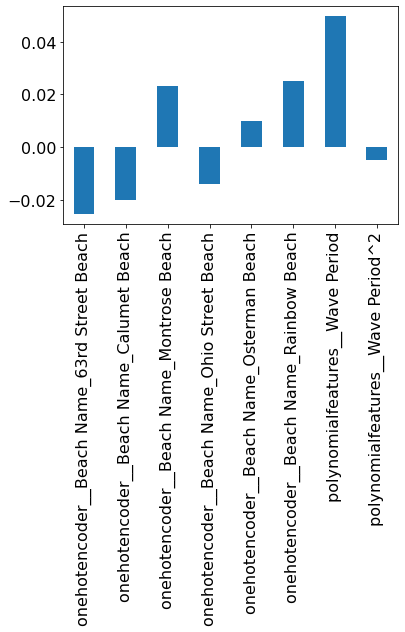

In [79]:
pd.Series(m4["lr"].coef_, index=m4["trans"].get_feature_names_out()).plot.bar()